In [1]:
from pyspark.sql import SparkSession
import importlib.util
import os

# ========== LOAD CONFIG FIRST ==========
src_path = os.path.join(os.path.dirname(os.getcwd()), 'src')
config_file = os.path.join(src_path, 'config.py')

spec = importlib.util.spec_from_file_location("config", config_file)
config_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_module)

Config = config_module.Config
print("✓ Config loaded")

# ========== STOP EXISTING SPARK ==========
try:
    spark.stop()
    print("✓ Stopped existing Spark session")
except:
    print("ℹ No existing Spark session to stop")

# ========== CREATE SPARK SESSION ==========
print(f"Creating Spark session: {Config.APP_NAME}")

spark = SparkSession.builder \
    .appName(Config.APP_NAME) \
    .config("spark.driver.memory", Config.SPARK_DRIVER_MEMORY) \
    .config("spark.executor.memory", Config.SPARK_EXECUTOR_MEMORY) \
    .config("spark.executor.instances", Config.SPARK_EXECUTOR_INSTANCES) \
    .config("spark.executor.cores", Config.SPARK_EXECUTOR_CORES) \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,com.amazonaws:aws-java-sdk-bundle:1.12.262") \
    .getOrCreate()

print(f"✓ Spark session created successfully (version {spark.version})")

# ========== CONFIGURE HADOOP FOR MINIO ==========
print("Configuring Hadoop for MinIO...")

hadoop_conf = spark._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3a.endpoint", Config.MINIO_ENDPOINT)
hadoop_conf.set("fs.s3a.access.key", Config.MINIO_ACCESS_KEY)
hadoop_conf.set("fs.s3a.secret.key", Config.MINIO_SECRET_KEY)
hadoop_conf.set("fs.s3a.path.style.access", "true")
hadoop_conf.set("fs.s3a.connection.ssl.enabled", "false")
hadoop_conf.set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")

print(f"✓ Spark configured for environment: {Config.ENVIRONMENT}")
print(f"✓ Using MinIO endpoint: {Config.MINIO_ENDPOINT}")
print(f"✓ Reading from bucket: {Config.S3_BUCKET_NAME}")

print("\n" + "="*50)
print("✓ Spark Session Ready")
print("="*50)

# Display configuration
Config.display_config()

✓ Config loaded
ℹ No existing Spark session to stop
Creating Spark session: NYC Taxi EDA
✓ Spark session created successfully (version 3.5.0)
Configuring Hadoop for MinIO...
✓ Spark configured for environment: development
✓ Using MinIO endpoint: http://minio:9000
✓ Reading from bucket: nyc-taxi

✓ Spark Session Ready
Current Configuration:
App Name: NYC Taxi EDA
Environment: development
MinIO Endpoint: http://minio:9000
S3 Bucket: nyc-taxi
Spark Driver Memory: 3g
Spark Executor Memory: 3g
Spark Executor Instances: 3
Spark Executor Cores: 2
Log Level: INFO
Log File: eda.log


In [2]:
df = spark.read.parquet("s3a://nyc-taxi/Clean_DF/")

In [3]:
df.coalesce(6)

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double, cbd_congestion_fee: double]

### Tip Estimation Model

In [4]:
from pyspark.sql.functions import (
    hour, dayofweek, month, when, sqrt, 
    unix_timestamp, cos, sin, radians, concat
)

from pyspark.sql.functions import col, lit

df_tips1 = df.select("tip_amount", "fare_amount", "trip_distance", "payment_type", "PULocationID", "DOLocationID", "tpep_pickup_datetime", "tpep_dropoff_datetime")

df_tips1 = df_tips1.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
       .withColumn("pickup_day", dayofweek("tpep_pickup_datetime")) \
       .withColumn("pickup_month", month("tpep_pickup_datetime")) \
       .withColumn("is_weekend", when(col("pickup_day").isin([1, 7]), 1).otherwise(0)) \
       .withColumn("is_rush_hour", when(
           ((col("pickup_hour") >= 6) & (col("pickup_hour") <= 10)) | 
           ((col("pickup_hour") >= 16) & (col("pickup_hour") <= 20)), 1
       ).otherwise(0)) \
       .withColumn("is_night", when(
           ((col("pickup_hour") >= 20) | (col("pickup_hour") <= 6)), 1
       ).otherwise(0)) \
       .withColumn("tip_percent", (col("tip_amount") / col("fare_amount")) * 100) \
       .withColumn("PU_DO_pair", concat(col("PULocationID").cast("string"), lit("_"), col("DOLocationID").cast("string")))

In [16]:
df_tips1.show()

+----------+-----------+-------------+------------+------------+------------+--------------------+---------------------+-----------+----------+------------+----------+------------+--------+------------------+----------+
|tip_amount|fare_amount|trip_distance|payment_type|PULocationID|DOLocationID|tpep_pickup_datetime|tpep_dropoff_datetime|pickup_hour|pickup_day|pickup_month|is_weekend|is_rush_hour|is_night|       tip_percent|PU_DO_pair|
+----------+-----------+-------------+------------+------------+------------+--------------------+---------------------+-----------+----------+------------+----------+------------+--------+------------------+----------+
|       0.0|        9.3|         0.97|           2|         161|         141| 2023-01-01 00:32:10|  2023-01-01 00:40:36|          0|         1|           1|         1|           0|       0|               0.0|   161_141|
|       4.0|        7.9|          1.1|           1|          43|         237| 2023-01-01 00:55:08|  2023-01-01 01:01:27|

The payment_type 2 (Cash) consistently shows a tip_amount of 0.0. This isn't necessarily because passengers didn't tip, but because cash tips aren't recorded in the system. Likewise, other payment systems are also not much helpful here. Therefore, we need to filter them out.

In [5]:
df_tips1 = df_tips1.filter(col("payment_type") == 1)

In [6]:
df_tips1.count()

79757391

Before moving ahead with the columns to aggregate data based on, let's take a look at how much they effect the avg tip percent data.

In [19]:
df_tips1.groupBy('is_night').avg('tip_percent').show()

+--------+------------------+
|is_night|  avg(tip_percent)|
+--------+------------------+
|       1|25.652914971662863|
|       0| 25.45770167729256|
+--------+------------------+



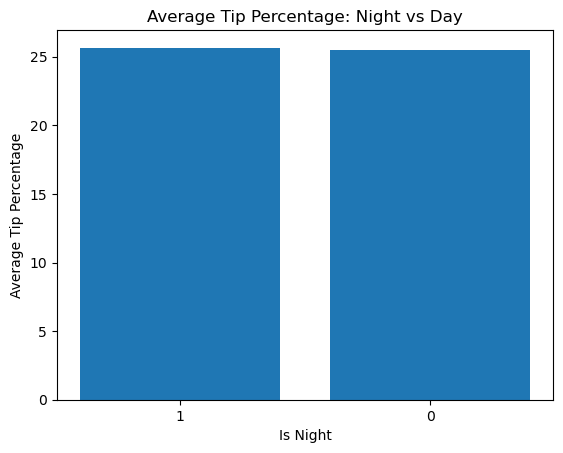

In [7]:
# Convert Spark result to Pandas
avg_tip_df = (
    df_tips1
    .groupBy('is_night')
    .avg('tip_percent')
    .toPandas()
)

# Rename columns for clarity
avg_tip_df.columns = ['is_night', 'avg_tip_percent']

# Plot
import matplotlib.pyplot as plt

plt.figure()
plt.bar(
    avg_tip_df['is_night'].astype(str),
    avg_tip_df['avg_tip_percent']
)
plt.xlabel('Is Night')
plt.ylabel('Average Tip Percentage')
plt.title('Average Tip Percentage: Night vs Day')
plt.show()


In [20]:
df_tips1.groupBy('is_rush_hour').avg('tip_percent').show()

+------------+------------------+
|is_rush_hour|  avg(tip_percent)|
+------------+------------------+
|           1|25.954784225899857|
|           0|25.088459399006698|
+------------+------------------+



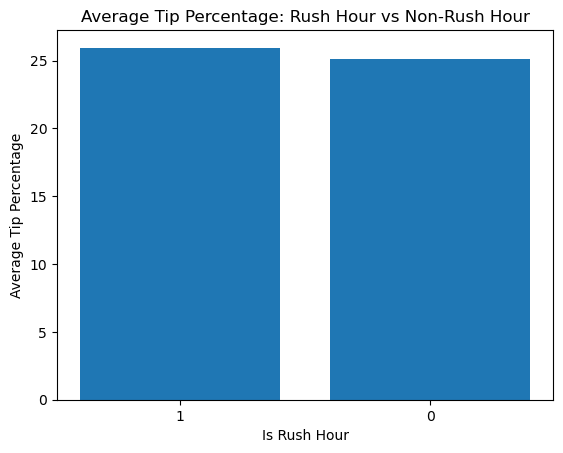

In [8]:
# Convert Spark result to Pandas
avg_tip_df = (
    df_tips1
    .groupBy('is_rush_hour')
    .avg('tip_percent')
    .toPandas()
)

# Rename columns
avg_tip_df.columns = ['is_rush_hour', 'avg_tip_percent']

# Plot
import matplotlib.pyplot as plt

plt.figure()
plt.bar(
    avg_tip_df['is_rush_hour'].astype(str),
    avg_tip_df['avg_tip_percent']
)
plt.xlabel('Is Rush Hour')
plt.ylabel('Average Tip Percentage')
plt.title('Average Tip Percentage: Rush Hour vs Non-Rush Hour')
plt.show()


In [21]:
df_tips1.groupBy('is_weekend').avg('tip_percent').show()

+----------+------------------+
|is_weekend|  avg(tip_percent)|
+----------+------------------+
|         1|24.828555103618953|
|         0| 25.76748909972411|
+----------+------------------+



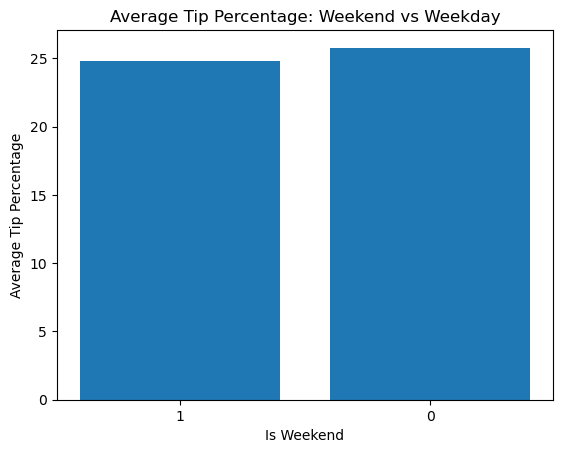

In [9]:
# Convert Spark result to Pandas
avg_tip_df = (
    df_tips1
    .groupBy('is_weekend')
    .avg('tip_percent')
    .toPandas()
)

# Rename columns
avg_tip_df.columns = ['is_weekend', 'avg_tip_percent']

# Plot
import matplotlib.pyplot as plt

plt.figure()
plt.bar(
    avg_tip_df['is_weekend'].astype(str),
    avg_tip_df['avg_tip_percent']
)
plt.xlabel('Is Weekend')
plt.ylabel('Average Tip Percentage')
plt.title('Average Tip Percentage: Weekend vs Weekday')
plt.show()


In [22]:
df_tips1.groupBy('pickup_month').avg('tip_percent').show()

+------------+------------------+
|pickup_month|  avg(tip_percent)|
+------------+------------------+
|          12|25.094430361089938|
|           1| 26.17986607994806|
|          10|  25.1045627233786|
|           2|25.640637133914066|
|           9|24.462165139128004|
|          11|25.838064580083504|
|           6| 25.39009100305301|
|           5|25.176676371847293|
|           4|25.833125426733066|
|           8|25.085676363384053|
|           7| 26.04541650619972|
|           3|25.861159713259585|
+------------+------------------+



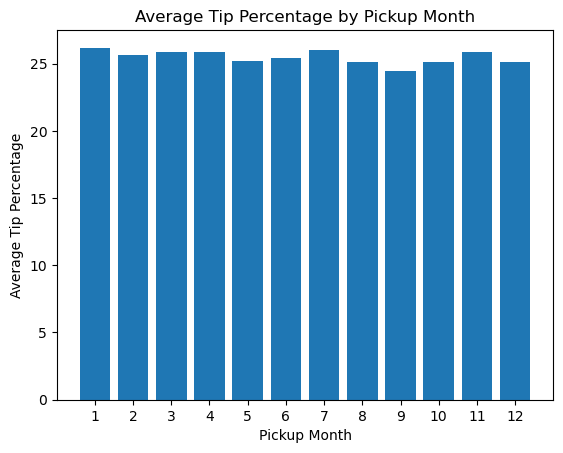

In [10]:
# Convert Spark result to Pandas
avg_tip_df = (
    df_tips1
    .groupBy('pickup_month')
    .avg('tip_percent')
    .toPandas()
)

# Rename columns
avg_tip_df.columns = ['pickup_month', 'avg_tip_percent']

# Sort by month
avg_tip_df = avg_tip_df.sort_values('pickup_month')

# Plot
import matplotlib.pyplot as plt

plt.figure()
plt.bar(
    avg_tip_df['pickup_month'].astype(str),
    avg_tip_df['avg_tip_percent']
)
plt.xlabel('Pickup Month')
plt.ylabel('Average Tip Percentage')
plt.title('Average Tip Percentage by Pickup Month')
plt.show()


In [23]:
df_tips1.groupBy('pickup_day').avg('tip_percent').show()

+----------+------------------+
|pickup_day|  avg(tip_percent)|
+----------+------------------+
|         1| 24.68717291108004|
|         6|25.410508234716264|
|         3| 25.90459606725041|
|         5|26.139571511754323|
|         4| 25.62878622528968|
|         7| 24.94809902633729|
|         2|25.726623277243664|
+----------+------------------+



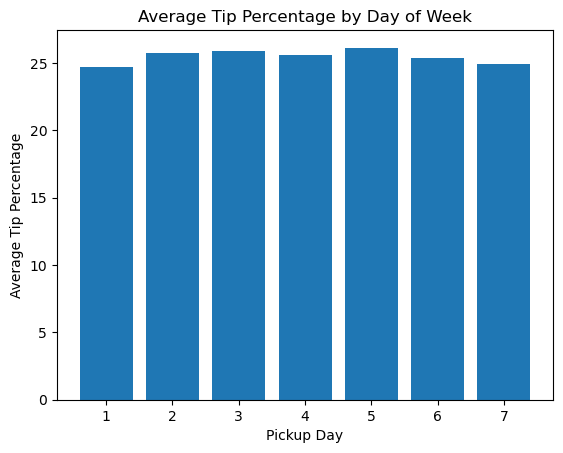

In [11]:
# Convert Spark result to Pandas
avg_tip_df = (
    df_tips1
    .groupBy('pickup_day')
    .avg('tip_percent')
    .toPandas()
)

# Rename columns
avg_tip_df.columns = ['pickup_day', 'avg_tip_percent']

# Sort by day index
avg_tip_df = avg_tip_df.sort_values('pickup_day')

# Plot
import matplotlib.pyplot as plt

plt.figure()
plt.bar(
    avg_tip_df['pickup_day'].astype(str),
    avg_tip_df['avg_tip_percent']
)
plt.xlabel('Pickup Day')
plt.ylabel('Average Tip Percentage')
plt.title('Average Tip Percentage by Day of Week')
plt.show()


In [24]:
df_tips1.groupBy('pickup_hour').avg('tip_percent').show()

+-----------+------------------+
|pickup_hour|  avg(tip_percent)|
+-----------+------------------+
|         12|24.321234681388066|
|         22|25.501986294332305|
|          1|25.076702127132897|
|         13|24.750965118406594|
|          6|26.507472521438352|
|         16|26.181031922599008|
|          3|25.194811575017702|
|         20|25.841446947656554|
|          5| 23.15155688651097|
|         19| 27.32282026567797|
|         15|24.898389362389395|
|          9|  24.4288315248703|
|         17|26.509070491832205|
|          4|28.874924322051587|
|          8| 24.52653518680321|
|         23|25.519452570890802|
|          7|24.571234304755865|
|         10|  24.6742172351314|
|         21| 25.66991246508552|
|         11|25.246506511408157|
+-----------+------------------+
only showing top 20 rows



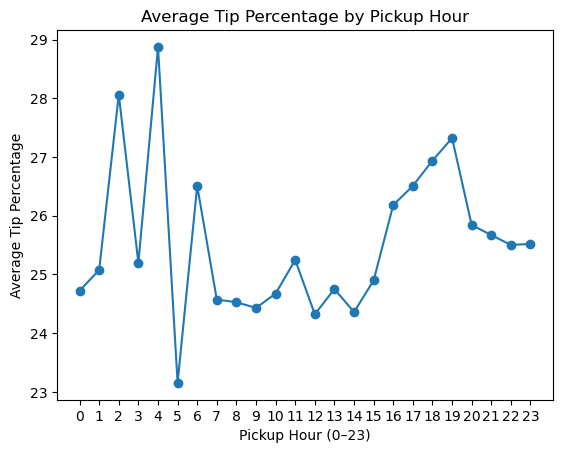

In [12]:
# Convert Spark result to Pandas
avg_tip_df = (
    df_tips1
    .groupBy('pickup_hour')
    .avg('tip_percent')
    .toPandas()
)

# Rename columns
avg_tip_df.columns = ['pickup_hour', 'avg_tip_percent']

# Sort by hour
avg_tip_df = avg_tip_df.sort_values('pickup_hour')

# Plot
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    avg_tip_df['pickup_hour'],
    avg_tip_df['avg_tip_percent'],
    marker='o'
)
plt.xlabel('Pickup Hour (0–23)')
plt.ylabel('Average Tip Percentage')
plt.title('Average Tip Percentage by Pickup Hour')
plt.xticks(range(0, 24))
plt.show()


In [25]:
from pyspark.sql.functions import avg, max as spark_max, min as spark_min

def effect_size(df, group_col, target="tip_percent"):
    ag = df.groupBy(group_col).agg(avg(target).alias("avg_tip"))
    return ag.agg((spark_max("avg_tip") - spark_min("avg_tip")).alias("effect_size"))

# Examples
effect_size(df_tips1, "pickup_hour").show()
effect_size(df_tips1, "pickup_month").show()
effect_size(df_tips1, "is_weekend").show()
effect_size(df_tips1, "is_rush_hour").show()
effect_size(df_tips1, "is_night").show()

+------------------+
|       effect_size|
+------------------+
|5.7233674355406166|
+------------------+

+------------------+
|       effect_size|
+------------------+
|1.7177009408200554|
+------------------+

+------------------+
|       effect_size|
+------------------+
|0.9389339961051562|
+------------------+

+------------------+
|       effect_size|
+------------------+
|0.8663248268931589|
+------------------+

+-------------------+
|        effect_size|
+-------------------+
|0.19521329437030133|
+-------------------+



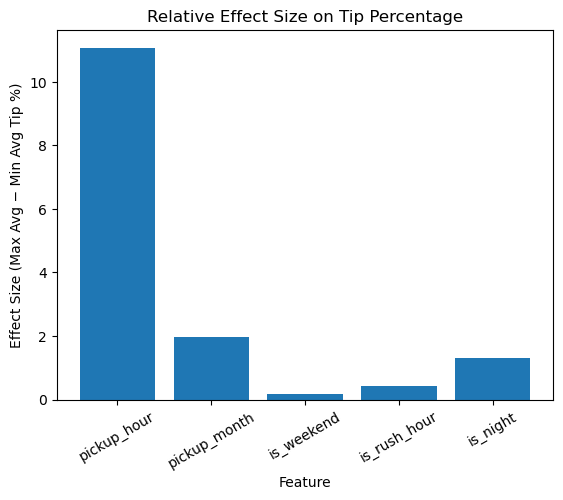

In [6]:
from pyspark.sql.functions import avg, max as spark_max, min as spark_min
import matplotlib.pyplot as plt

def effect_size_value(df, group_col, target="tip_percent"):
    ag = df.groupBy(group_col).agg(avg(target).alias("avg_tip"))
    return ag.agg((spark_max("avg_tip") - spark_min("avg_tip")).alias("effect_size")) \
             .collect()[0]["effect_size"]

# Compute effect sizes
features = [
    "pickup_hour",
    "pickup_month",
    "is_weekend",
    "is_rush_hour",
    "is_night"
]

effect_sizes = [effect_size_value(df_tips1, f) for f in features]

# Plot
plt.figure()
plt.bar(features, effect_sizes)
plt.ylabel("Effect Size (Max Avg − Min Avg Tip %)")
plt.xlabel("Feature")
plt.title("Relative Effect Size on Tip Percentage")
plt.xticks(rotation=30)
plt.show()


Turns out:

1. pickup_hour shows the largest spread → strong signal
2. pickup_month shows a small-to-moderate spread → useful but weaker
3. is_weekend / is_rush_hour / is_night → small effects, still useful as filters/controls but not primary drivers

In [29]:
from pyspark.sql.functions import avg, count, round

df_tips1.groupBy(
    "PULocationID", "DOLocationID", "pickup_hour", "pickup_month", "is_weekend", "is_rush_hour"
).agg(
    round(avg("tip_percent"), 2).alias("avg_tip_percent"),
    round(avg("tip_amount"), 2).alias("avg_tip_amount"),
    count("*").alias("rides")
).show()

+------------+------------+-----------+------------+----------+------------+---------------+--------------+-----+
|PULocationID|DOLocationID|pickup_hour|pickup_month|is_weekend|is_rush_hour|avg_tip_percent|avg_tip_amount|rides|
+------------+------------+-----------+------------+----------+------------+---------------+--------------+-----+
|          50|         186|          0|           1|         1|           0|          27.05|           2.7|    9|
|         236|         262|          0|           1|         1|           0|          44.68|          3.17|   45|
|          48|         260|          0|           1|         1|           0|          24.25|          7.15|    6|
|          90|         142|          0|           1|         1|           0|          21.21|          3.42|   45|
|           7|         116|          0|           1|         1|           0|          33.24|          9.14|    1|
|         229|         162|          1|           1|         1|           0|          32

Many of the rides here too less to give us a good average of tip percentage. Therefore we have created a function below that keeps dropping the lowest priority aggregations until the count of rides reaches at least 100.

In [38]:
from pyspark.sql.functions import col, avg, count, round

def get_avg_tip_percent_with_fallback(
    df,
    pu_location_id,
    do_location_id,
    pickup_hour,
    pickup_month,
    is_weekend,
    is_rush_hour,
    is_night,
    min_rides=100
):
    """
    Returns avg_tip_percent using fallback logic if rides are low.
    
    Priority of dropping filters (lowest priority dropped first):
    is_night -> is_rush_hour -> is_weekend -> pickup_month
    
    Output columns:
    avg_tip_percent, avg_tip_amount, rides_used
    """

    # Each step contains filters to apply
    # We start with the most strict filters
    fallback_steps = [
        {
            "fallback_level": "FULL (PU+DO+hour+month+weekend+rush+night)",
            "filters": [
                col("PULocationID") == pu_location_id,
                col("DOLocationID") == do_location_id,
                col("pickup_hour") == pickup_hour,
                col("pickup_month") == pickup_month,
                col("is_weekend") == is_weekend,
                col("is_rush_hour") == is_rush_hour,
                col("is_night") == is_night,
            ],
        },
        {
            "fallback_level": "DROP is_night",
            "filters": [
                col("PULocationID") == pu_location_id,
                col("DOLocationID") == do_location_id,
                col("pickup_hour") == pickup_hour,
                col("pickup_month") == pickup_month,
                col("is_weekend") == is_weekend,
                col("is_rush_hour") == is_rush_hour,
            ],
        },
        {
            "fallback_level": "DROP is_night + is_rush_hour",
            "filters": [
                col("PULocationID") == pu_location_id,
                col("DOLocationID") == do_location_id,
                col("pickup_hour") == pickup_hour,
                col("pickup_month") == pickup_month,
                col("is_weekend") == is_weekend,
            ],
        },
        {
            "fallback_level": "DROP is_night + is_rush_hour + is_weekend",
            "filters": [
                col("PULocationID") == pu_location_id,
                col("DOLocationID") == do_location_id,
                col("pickup_hour") == pickup_hour,
                col("pickup_month") == pickup_month,
            ],
        },
        {
            "fallback_level": "DROP is_night + is_rush_hour + is_weekend + pickup_month",
            "filters": [
                col("PULocationID") == pu_location_id,
                col("DOLocationID") == do_location_id,
                col("pickup_hour") == pickup_hour,
            ],
        },
    ]

    for step in fallback_steps:
        # Apply filters
        filtered_df = df
        for f in step["filters"]:
            filtered_df = filtered_df.filter(f)

        # Count rides
        rides = filtered_df.count()

        # If enough rides, calculate avg tip percent and return
        if rides >= min_rides:
            result = filtered_df.agg(
                round(avg("tip_percent"), 2).alias("avg_tip_percent"),
                round(avg("tip_amount"), 2).alias("avg_tip_amount"),
                count("*").alias("rides_used")
            )

            return result

    # If even last fallback doesn't reach min rides, return whatever exists (even if low)
    from pyspark.sql.functions import lit
    last_df = df.filter(
        (col("PULocationID") == pu_location_id) &
        (col("DOLocationID") == do_location_id) &
        (col("pickup_hour") == pickup_hour)
    )

    return last_df.agg(
        round(avg("tip_percent"), 2).alias("avg_tip_percent"),
        round(avg("tip_amount"), 2).alias("avg_tip_amount"),
        count("*").alias("rides_used"),
    )

In [39]:
# Testing the function for a random set of values.

result_df = get_avg_tip_percent_with_fallback(
    df=df_tips1,
    pu_location_id=161,
    do_location_id=141,
    pickup_hour=20,
    pickup_month=1,
    is_weekend=1,
    is_rush_hour=0,
    is_night=1,
    min_rides=100
)

result_df.show(truncate=False)

+---------------+----------+--------------+
|avg_tip_percent|rides_used|avg_tip_amount|
+---------------+----------+--------------+
|27.23          |974       |2.91          |
+---------------+----------+--------------+



In [16]:
df_tips1.count()

79757391

In [9]:
from pyspark.sql.functions import avg, count, round

streamlit_dataset_1 = df_tips1.groupBy(
    "PULocationID", "DOLocationID", "pickup_hour", "pickup_month", "is_weekend"
).agg(
    round(avg("tip_percent"), 2).alias("avg_tip_percent"),
    round(avg("tip_amount"), 2).alias("avg_tip_amount"),
    round(avg("fare_amount"), 2).alias("avg_fare_amount"),
    count("*").alias("rides")
)

In [10]:
# Save this for the tip estimation model
streamlit_dataset_1.write.mode("overwrite") \
    .parquet("s3a://nyc-taxi/Streamlit_Tips_Estimate_DF")

In [11]:
# Save df_tips1 for the nearby hotspots suggestion model
df_tips1.write.mode("overwrite") \
    .parquet("s3a://nyc-taxi/Nearby_Hotspots_DF")

In [12]:
# Creating a sample dataframe to be used to create the ML model for tip amount range prediction
tip_prediction_model_df = df_tips1.sample(fraction=0.1, seed=42)

In [13]:
# Save this for the tip amount range prediction
tip_prediction_model_df.write.mode("overwrite") \
    .parquet("s3a://nyc-taxi/Tip_Prediction_Model_DF")